In [11]:
import yfinance as yf
import pandas as pd
import ta  # Technical Analysis library
from sklearn.model_selection import train_test_split

# 사용할 주식 티커 목록
tickers = ["HBI", "GM", "BXP"]

data = {}

# 각 티커에 대해 데이터를 다운로드하고 데이터프레임에 저장
for ticker in tickers:
    df = yf.download(ticker, start='2018-01-01', end='2024-01-01')
    df.rename(columns={
        'Open': f'{ticker}_Open',
        'High': f'{ticker}_High',
        'Low': f'{ticker}_Low',
        'Close': f'{ticker}_Close',
        'Volume': f'{ticker}_Volume',
        'Adj Close': f'{ticker}_Adj_Close'
    }, inplace=True)
    df[f'{ticker}_ticker'] = ticker  # 티커 열 추가
    data[ticker] = df

# 데이터프레임을 동일한 날짜 인덱스로 결합
combined_df = pd.concat(data.values(), axis=1)

# 결합된 데이터프레임에 기술 지표 추가
for ticker in tickers:
    # 상대 강도 지수 (RSI: Relative Strength Index)
    combined_df[f'{ticker}_RSI'] = ta.momentum.RSIIndicator(combined_df[f'{ticker}_Close'], window=14).rsi()

    # 볼린저 밴드 (Bollinger Bands)
    bollinger = ta.volatility.BollingerBands(combined_df[f'{ticker}_Close'], window=20, window_dev=2)
    combined_df[f'{ticker}_BB_High'] = bollinger.bollinger_hband()
    combined_df[f'{ticker}_BB_Low'] = bollinger.bollinger_lband()
    combined_df[f'{ticker}_BB_Middle'] = bollinger.bollinger_mavg()

    # NaN 값을 각 feature의 평균으로 대체
    combined_df[f'{ticker}_RSI'].fillna(combined_df[f'{ticker}_RSI'].mean(), inplace=True)
    combined_df[f'{ticker}_BB_High'].fillna(combined_df[f'{ticker}_BB_High'].mean(), inplace=True)
    combined_df[f'{ticker}_BB_Low'].fillna(combined_df[f'{ticker}_BB_Low'].mean(), inplace=True)
    combined_df[f'{ticker}_BB_Middle'].fillna(combined_df[f'{ticker}_BB_Middle'].mean(), inplace=True)

# 필요한 열 선택 (모든 feature 포함)
features = []
for ticker in tickers:
    features.extend([f'{ticker}_Open', f'{ticker}_High', f'{ticker}_Low', f'{ticker}_Close', f'{ticker}_Volume', f'{ticker}_RSI', f'{ticker}_BB_High', f'{ticker}_BB_Low', f'{ticker}_BB_Middle', f'{ticker}_ticker'])

combined_df = combined_df[features]

# 데이터프레임을 70% 훈련 세트와 30% 테스트 세트로 분할
train_df, test_df = train_test_split(combined_df, test_size=0.3, shuffle=False)

# 'Date'를 인덱스로 설정 (필요한 경우)
train_df.index.name = 'Date'
test_df.index.name = 'Date'

print("Train Set:")
print(train_df.head())
print("Test Set:")
print(test_df.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Train Set:
             HBI_Open   HBI_High    HBI_Low  HBI_Close  HBI_Volume    HBI_RSI  \
Date                                                                            
2018-01-02  21.000000  21.639999  20.930000  21.299999     4906900  47.689706   
2018-01-03  21.340000  21.459999  20.910000  21.030001     3093300  47.689706   
2018-01-04  21.120001  21.290001  20.850000  21.260000     4158200  47.689706   
2018-01-05  21.290001  21.350000  21.020000  21.230000     4362300  47.689706   
2018-01-08  21.299999  21.840000  21.299999  21.600000     5278300  47.689706   

            HBI_BB_High  HBI_BB_Low  HBI_BB_Middle HBI_ticker  ...  \
Date                                                           ...   
2018-01-02    14.887307   12.554393       13.72085        HBI  ...   
2018-01-03    14.887307   12.554393       13.72085        HBI  ...   
2018-01-04    14.887307   12.554393       13.72085        HBI  ...   
2018-01-05    14.887307   12.554393       13.72085        HBI  ...   
2

In [50]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
import torch
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

cumu_lst = []
cumu_hap = 0

class StockTradingEnv(gym.Env):
    global cumu_lst, cumu_hap
    metadata = {'render.modes': ['human']}

    def __init__(self, df_list, initial_balance=100000):
        super(StockTradingEnv, self).__init__()

        self.df_list = [df.drop(columns=[col for col in df.columns if 'ticker' in col]) for df in df_list]  # ticker 열 제거
        self.n_stocks = len(df_list)
        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)  # 각 주식에 대해 Buy, Hold, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_stocks, len(self.df_list[0].columns)), dtype=np.float32)

        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 0
        self.done = False
        self.total_profit = 0
        self.inventory = [[] for _ in range(self.n_stocks)]
        self.balance = self.initial_balance
        self.state = np.array([df.iloc[self.current_step].values for df in self.df_list])
        self.returns = [0]

        return self.state

    def step(self, action):
        global cumu_lst
        self.done = self.current_step >= len(self.df_list[0]) - 1
        reward = 0
        additional_reward = 0

        for i, act in enumerate(action):
            if act == 0 and not self.done:  # Buy
                if self.balance >= self.state[i][3]:  # Check if balance is sufficient to buy
                    self.inventory[i].append(self.state[i][3])  # Close price
                    self.balance -= self.state[i][3]

            elif act == 1 and not self.done:  # Sell
                if len(self.inventory[i]) > 0:
                    bought_price = self.inventory[i].pop(0)
                    reward += self.state[i][3] - bought_price  # Current price - Bought price
                    self.total_profit += reward
                    self.balance += self.state[i][3]

            # 추가된 보상 요소들
            if self.state[i][5] >= 70 and act == 1:  # RSI가 70 이상일 때 매도
                additional_reward += 0.215
            elif self.state[i][5] <= 30 and act == 0:  # RSI가 30 이하일 때 매수
                additional_reward += 0.215

            if self.state[i][3] >= self.state[i][6] and act == 1:  # 주가가 BB 상한선 이상일 때 매도
                additional_reward += 0.215
            elif self.state[i][3] <= self.state[i][7] and act == 0:  # 주가가 BB 하한선 이하일 때 매수
                additional_reward += 0.215

            if self.state[i][4] > self.df_list[i].iloc[:, 4].mean() and (act == 0 or act == 1):  # 거래량이 평균 이상일 때 매수 또는 매도
                additional_reward += 0.215

        total_reward = reward + additional_reward

        # Sharpe Ratio
        if len(self.returns) > 1:
            sharpe_ratio = np.mean(self.returns) / (np.std(self.returns) + 1e-10)
        else:
            sharpe_ratio = 0

        # Drawdown
        peak = np.max(self.returns)
        drawdown = peak - self.returns[-1]

        # 정규화된 Sharpe Ratio와 Drawdown
        normalized_sharpe = np.tanh(sharpe_ratio)  # -1에서 1 사이로 정규화
        normalized_drawdown = np.tanh(drawdown)  # -1에서 1 사이로 정규화

        # 스케일링 팩터
        sharpe_scale = 0.5
        drawdown_scale = 0.5

        # 보상 함수에 샤프 비율과 드로우다운 포함
        stability_bonus = sharpe_scale * normalized_sharpe - drawdown_scale * normalized_drawdown
        total_reward += stability_bonus

        # Update returns
        self.returns.append(total_reward)

        if not self.done:
            self.current_step += 1
            self.state = np.array([df.iloc[self.current_step].values for df in self.df_list])
        else:
            self.state = np.zeros(self.observation_space.shape)  # Done 상태에서 반환할 값
            cumu_lst.append(self.total_profit)
            self.total_profit = 0

        return self.state, total_reward, self.done, {"reward": total_reward, "additional_reward": additional_reward, "sharpe_ratio": sharpe_ratio, "drawdown": drawdown, "stability_bonus": stability_bonus}

    def render(self, mode='human', close=False):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Total Profit: {self.total_profit}, Sharpe Ratio: {np.mean(self.returns) / np.std(self.returns) if len(self.returns) > 1 else 0}, Drawdown: {(self.max_balance - self.balance) / self.max_balance}')

In [36]:
class EvalCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(EvalCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.action_distribution = []
        self.state_visit_frequency = {}
        self.cumulative_rewards = []  # 누적 보상을 저장하기 위한 리스트

    def _on_step(self) -> bool:
        # Record current step action for action distribution analysis
        actions = self.locals["actions"].flatten()  # Flatten actions to 1D
        self.action_distribution.extend(actions)
        
        # Record state visit frequency
        state_str = str(self.locals["new_obs"])
        if state_str in self.state_visit_frequency:
            self.state_visit_frequency[state_str] += 1
        else:
            self.state_visit_frequency[state_str] = 1
        return True

    def _on_rollout_end(self) -> None:
        # Log the reward and length for each episode
        episode_reward = sum(self.locals["rewards"])
        episode_length = len(self.locals["rewards"])
        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(episode_length)
        self.cumulative_rewards.append(sum(self.episode_rewards))  # 누적 보상을 추가
        self.logger.record('rollout/episode_reward', np.sum(self.episode_rewards))
        self.logger.record('rollout/episode_length', np.sum(self.episode_lengths))

    def _on_training_end(self) -> None:
        # Save evaluation results to file or print them
        print(f"Mean episode reward: {np.mean(self.episode_rewards)}")
        print(f"Mean episode length: {np.mean(self.episode_lengths)}")
        print(f"Cumulative reward: {np.sum(self.episode_rewards)}")

        # Plot action distribution
        plt.figure(figsize=(12, 6))
        plt.hist(self.action_distribution, bins=3, align='left', rwidth=0.8)
        plt.xticks(range(3), ['Buy', 'Hold', 'Sell'])
        plt.xlabel('Actions')
        plt.ylabel('Frequency')
        plt.title('Action Distribution')
        plt.show()

        # Plot episode rewards
        plt.figure(figsize=(12, 6))
        plt.plot(self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title('Episode Reward over Episodes')
        plt.show()

        # Plot cumulative rewards
        plt.figure(figsize=(12, 6))
        plt.plot(self.cumulative_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.title('Cumulative Reward over Episodes')
        plt.show()

        # Plot state visit frequency
        state_visit_sorted = sorted(self.state_visit_frequency.items(), key=lambda item: item[1], reverse=True)
        states, visits = zip(*state_visit_sorted)
        plt.figure(figsize=(12, 6))
        plt.bar(states[:10], visits[:10])
        plt.xlabel('States')
        plt.ylabel('Visit Frequency')
        plt.title('Top 10 Most Visited States')
        plt.show()

Logging to ./ppo_stock_trading_v11


C:\Users\Joker\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
---------------------------------
| rollout/           |          |
|    episode_length  | 1        |
|    episode_reward  | -0.524   |
| time/              |          |
|    fps             | 197      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    episode_length       | 2           |
|    episode_reward       | -1          |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 2           |
|    time_elapsed         | 23          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009743712 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.29       |
|    explained_variance   | 0.000326    |
|    learnin

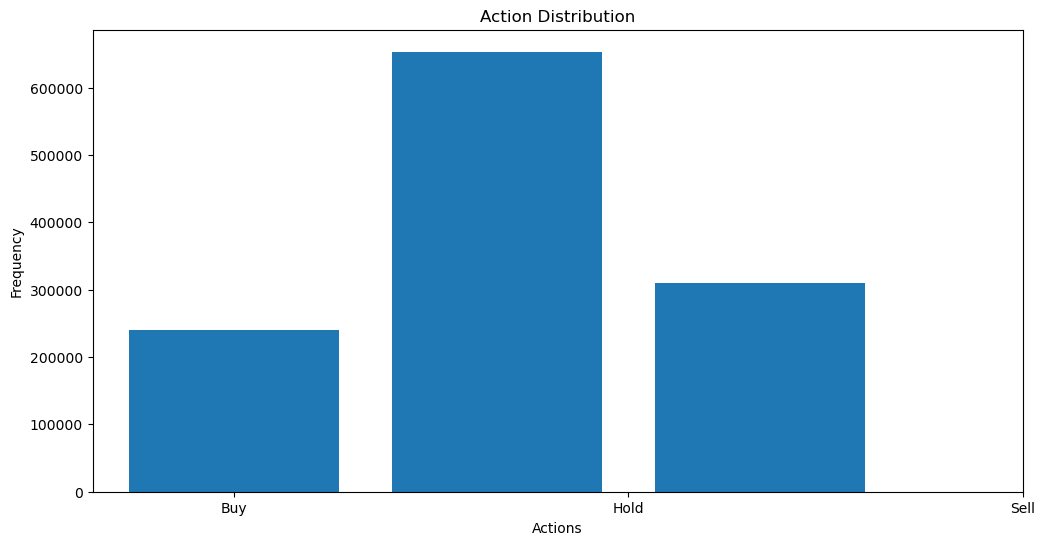

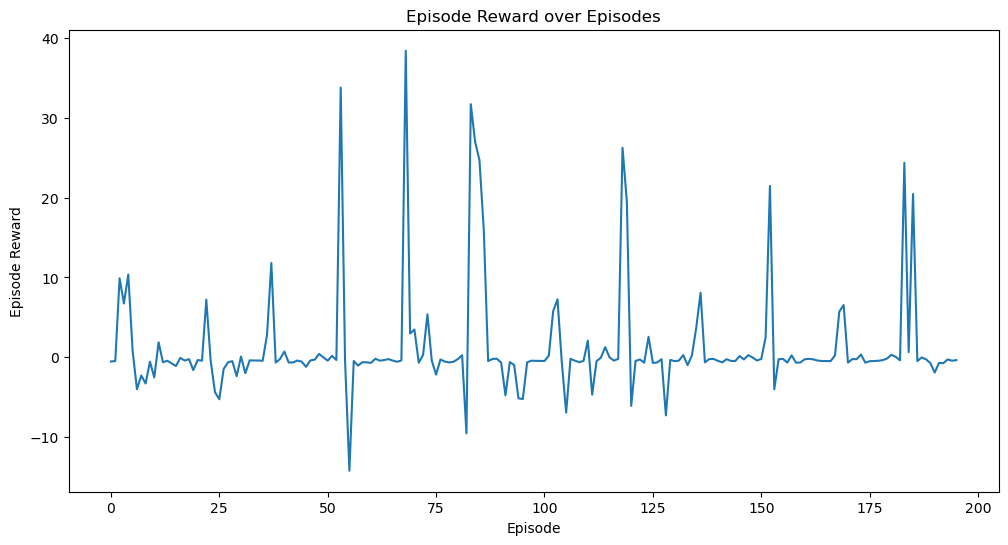

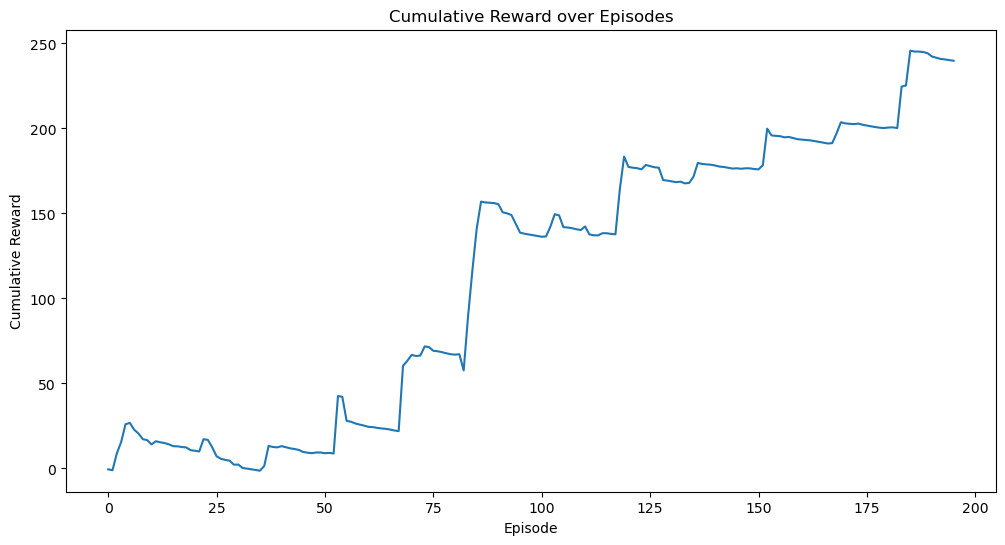

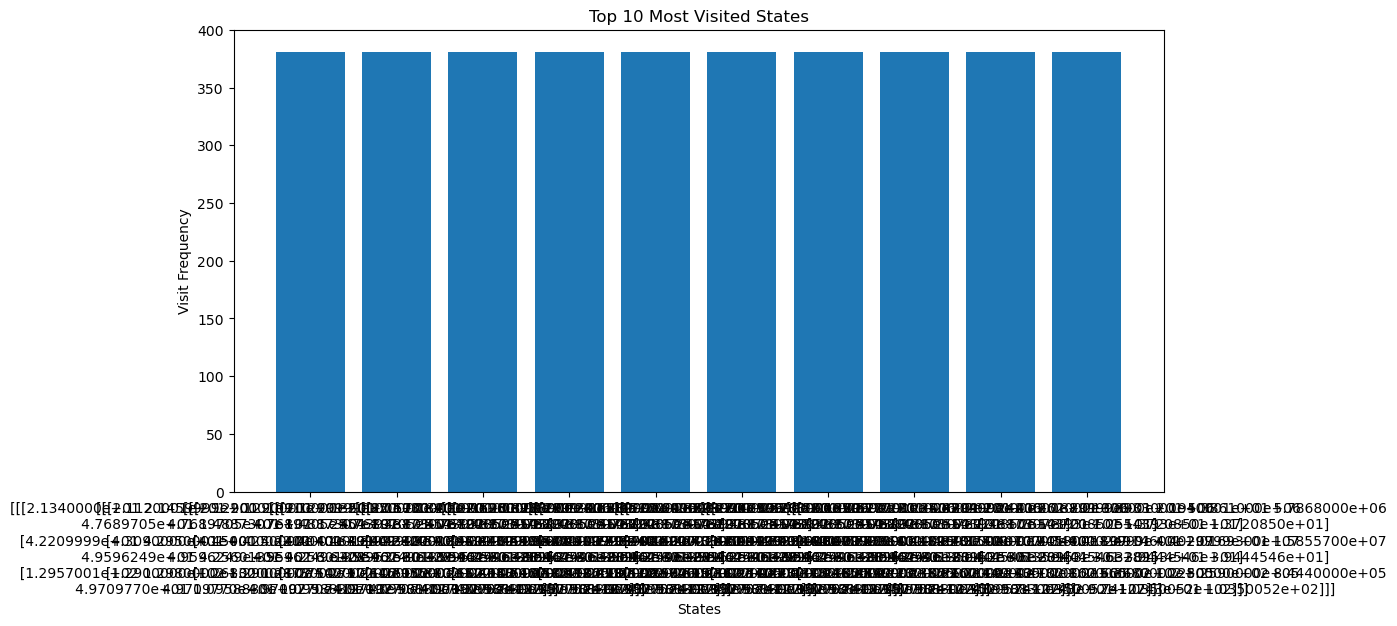

C:\Users\Joker\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\Joker\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Final Balance: 100000
Total Profit: 0
Total Rewards: -390.93325876222866
Total Additional Rewards: 111.58500000000062
Total Stability Bonus: -273.23824806200287
profit: -229.2800107002264


In [51]:
# 학습 환경 설정
train_df_list = [train_test_split(combined_df[[col for col in combined_df.columns if ticker in col]], test_size=0.3, shuffle=False)[0] for ticker in tickers]
test_df_list = [train_test_split(combined_df[[col for col in combined_df.columns if ticker in col]], test_size=0.3, shuffle=False)[1] for ticker in tickers]

train_env = DummyVecEnv([lambda: StockTradingEnv(train_df_list)])

# CUDA 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log_dir = "./ppo_stock_trading_v11"
os.makedirs(log_dir, exist_ok=True)
new_logger = configure(log_dir, ["stdout", "tensorboard"])

# PPO 모델 학습
from stable_baselines3.common.callbacks import CheckpointCallback

# 체크포인트 저장 콜백 설정 (예: 10000 타임스텝마다 저장)
checkpoint_callback = CheckpointCallback(save_freq=20000, save_path='./Multi_management_HBI_GM_BXP/Checkpoint_0.215/', name_prefix='ppo_stock_trading')

# PPO 모델 학습
model = PPO('MlpPolicy', train_env, verbose=1, device=device)
model.set_logger(new_logger)
model.learn(total_timesteps=400000, callback=[checkpoint_callback, EvalCallback()])

# 테스트 환경 설정
test_env = DummyVecEnv([lambda: StockTradingEnv(test_df_list)])

# 학습된 모델로 예측 및 결과 시각화
obs = test_env.reset()
total_rewards = 0
total_additional_rewards = 0
total_stability_bonus = 0

for _ in range(len(test_df_list[0])):
    action, _states = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    total_rewards += info[0]['reward']
    total_additional_rewards += info[0]['additional_reward']
    total_stability_bonus += info[0]['stability_bonus']
    test_env.render()
    if done:
        break

print(f"Final Balance: {test_env.get_attr('balance')[0]}")
print(f"Total Profit: {test_env.get_attr('total_profit')[0]}")
print(f"Total Rewards: {total_rewards}")
print(f"Total Additional Rewards: {total_additional_rewards}")
print(f"Total Stability Bonus: {total_stability_bonus}")
print(f"profit: {total_rewards - total_additional_rewards - total_stability_bonus}")

In [52]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# 데이터프레임을 70% 훈련 세트와 30% 테스트 세트로 분할
train_df_list = [train_test_split(combined_df[[col for col in combined_df.columns if ticker in col]], test_size=0.3, shuffle=False)[0] for ticker in tickers]
test_df_list = [train_test_split(combined_df[[col for col in combined_df.columns if ticker in col]], test_size=0.3, shuffle=False)[1] for ticker in tickers]

# 테스트 환경 설정
test_env = DummyVecEnv([lambda: StockTradingEnv(test_df_list)])

# 체크포인트 디렉토리 설정
checkpoint_dir = './Multi_management_HBI_GM_BXP/Checkpoint_0.215/'
checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.zip')]

results = []

# 각 체크포인트 평가
for checkpoint_file in checkpoint_files:
    model = PPO.load(checkpoint_file, env=test_env)

    obs = test_env.reset()
    total_rewards = 0
    total_additional_rewards = 0
    total_stability_bonus = 0
    done = False

    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info = test_env.step(action)
        total_rewards += info[0]['reward']
        total_additional_rewards += info[0]['additional_reward']
        total_stability_bonus += info[0]['stability_bonus']

    results.append({
        'checkpoint': checkpoint_file,
        'total_rewards': total_rewards,
        'total_profit': total_rewards - total_additional_rewards - total_stability_bonus,
        'total_additional_rewards': total_additional_rewards,
        'total_stability_bonus': total_stability_bonus,
    })

# 결과 출력
for result in results:
    print(f"Checkpoint: {result['checkpoint']}")
    print(f"Total Rewards: {result['total_rewards']}")
    print(f"Total Additional Rewards: {result['total_additional_rewards']}")
    print(f"Total Stability Bonus: {result['total_stability_bonus']}")
    print(f"Total Profit: {result['total_profit']}")
    print("="*50)


C:\Users\Joker\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Checkpoint: ./Multi_management_HBI_GM_BXP/Checkpoint_0.215/ppo_stock_trading_100000_steps.zip
Total Rewards: -409.68030048082596
Total Additional Rewards: 99.76000000000053
Total Stability Bonus: -286.4202656907871
Total Profit: -223.0200347900394
Checkpoint: ./Multi_management_HBI_GM_BXP/Checkpoint_0.215/ppo_stock_trading_120000_steps.zip
Total Rewards: -428.60775661170504
Total Additional Rewards: 104.70500000000064
Total Stability Bonus: -294.08273394286647
Total Profit: -239.23002266883924
Checkpoint: ./Multi_management_HBI_GM_BXP/Checkpoint_0.215/ppo_stock_trading_140000_steps.zip
Total Rewards: -460.3214215278838
Total Additional Rewards: 102.77000000000042
Total Stability Bonus: -278.69142286302747
Total Profit: -284.39999866485675
Checkpoint: ./Multi_management_HBI_GM_BXP/Checkpoint_0.215/ppo_stock_trading_160000_steps.zip
Total Rewards: -441.62166667250716
Total Additional Rewards: 117.60500000000069
Total Stability Bonus: -299.0966496303472
Total Profit: -260.1300170421606
Ch